## **KNN Model**

[*********************100%***********************]  1 of 1 completed
C:\Users\jainu\AppData\Local\Temp\ipykernel_16876\3636797386.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data.resample('M').last()


Confusion Matrix:
[[15  0  0]
 [ 0  5  0]
 [ 2  2  7]]

Classification Report:
              precision    recall  f1-score   support

   High Risk       0.88      1.00      0.94        15
    Low Risk       0.71      1.00      0.83         5
 Medium Risk       1.00      0.64      0.78        11

    accuracy                           0.87        31
   macro avg       0.87      0.88      0.85        31
weighted avg       0.90      0.87      0.86        31



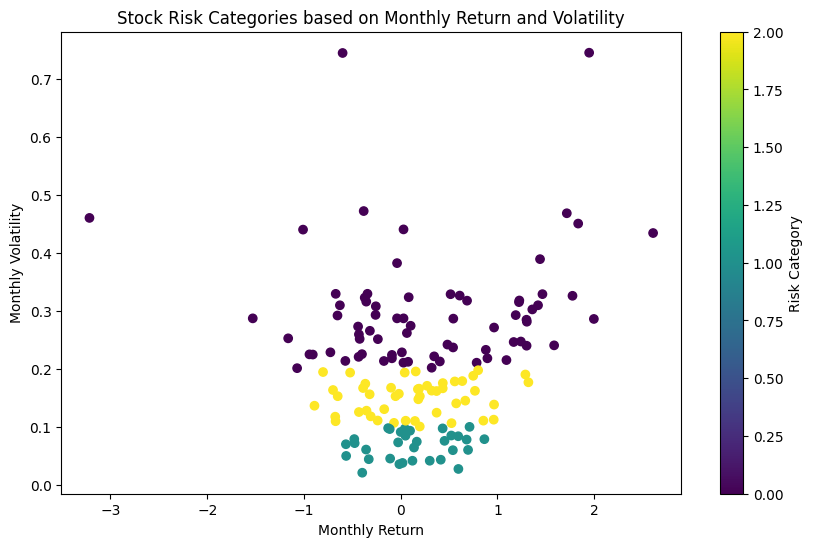

0-1 Loss (Misclassification Rate): 0.0270
Accuracy: 0.9730


In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Fetch stock data from Yahoo Finance
def fetch_stock_data(ticker, start='2010-01-01', end='2022-12-31'):
    stock_data = yf.download(ticker, start=start, end=end)
    stock_data['Returns'] = stock_data['Close'].pct_change()  # Calculate daily returns
    stock_data['Volatility'] = stock_data['Returns'].rolling(window=30).std()  # 30-day rolling volatility
    stock_data = stock_data.dropna()  # Drop missing values
    return stock_data

# Resample to monthly data
def process_monthly_data(data):
    # Resample data to monthly frequency, taking the last value of each month
    monthly_data = data.resample('M').last()
    
    # Calculate monthly returns
    monthly_data['Monthly Returns'] = monthly_data['Close'].pct_change()
    
    # Calculate monthly volatility (standard deviation of returns)
    monthly_data['Monthly Volatility'] = monthly_data['Monthly Returns'].rolling(window=3).std()  # 3-month rolling volatility
    monthly_data = monthly_data.dropna()  # Drop missing values
    
    # Calculate annualized monthly returns and volatility
    monthly_data['Monthly Return'] = monthly_data['Monthly Returns'] * 12  # 12 months in a year
    monthly_data['Monthly Volatility'] = monthly_data['Monthly Volatility'] * np.sqrt(12)  # Annualized volatility
    
    # Classify risk based on monthly volatility
    conditions = [
        (monthly_data['Monthly Volatility'] < 0.1),
        (monthly_data['Monthly Volatility'] >= 0.1) & (monthly_data['Monthly Volatility'] < 0.2),
        (monthly_data['Monthly Volatility'] >= 0.2)
    ]
    risk_categories = ['Low Risk', 'Medium Risk', 'High Risk']
    monthly_data['Risk Category'] = np.select(conditions, risk_categories)
    
    return monthly_data[['Monthly Return', 'Monthly Volatility', 'Risk Category']]

# Model training and evaluation
def run_knn_model(data):
    # Encode labels
    le = LabelEncoder()
    data['Risk Category'] = le.fit_transform(data['Risk Category'])

    # Features and Labels
    X = data[['Monthly Return', 'Monthly Volatility']]
    y = data['Risk Category']
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Feature Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # KNN model with hyperparameter tuning
    param_grid = {'n_neighbors': np.arange(3, 15)}
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
    grid_search.fit(X_train_scaled, y_train)
    
    # Best model after tuning
    best_model = grid_search.best_estimator_

    # Predictions and Evaluation
    y_pred = best_model.predict(X_test_scaled)

    # Confusion Matrix and Classification Report
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    return best_model

# Plotting the results (if needed)
def plot_results(data, model):
    plt.figure(figsize=(10, 6))
    plt.scatter(data['Monthly Return'], data['Monthly Volatility'], c=data['Risk Category'], cmap='viridis')
    plt.title('Stock Risk Categories based on Monthly Return and Volatility')
    plt.xlabel('Monthly Return')
    plt.ylabel('Monthly Volatility')
    plt.colorbar(label='Risk Category')
    plt.show()

if __name__ == "__main__":
    # Example: Running for one stock (e.g., HDFCBANK.NS)
    ticker = 'HDFCBANK.NS'
    stock_data = fetch_stock_data(ticker)
    processed_data = process_monthly_data(stock_data)
    
    # Run the KNN model
    best_knn_model = run_knn_model(processed_data)
    
    # Plot results
    plot_results(processed_data, best_knn_model)

from sklearn.metrics import zero_one_loss

# y_test: true labels
# y_pred: predicted labels from your KNN model

loss_01 = zero_one_loss(y_test, y_pred)
accuracy = 1 - loss_01

print(f"0-1 Loss (Misclassification Rate): {loss_01:.4f}")
print(f"Accuracy: {accuracy:.4f}")
